In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import non_max_suppression, decode_predictions, recognize

import gradio as gr

c:\Users\Acer\anaconda3\envs\PytorchCuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def text_detection(image, max_img = 5, size=(320, 320), east_path='saved_models/frozen_east_text_detection.pb', min_confidence=0.5):
    orig = image.copy()
    (H, W) = image.shape[:2]

    (newW, newH) = size
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    layerNames = [ "feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

    net = cv2.dnn.readNet(east_path)
    
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    
    rects, confidences = decode_predictions(scores, geometry, min_confidence)
    
    boxes, pick_probs = non_max_suppression(np.array(rects), probs=confidences)
    res_list = []

    result = orig.copy()
    for (startX, startY, endX, endY) in boxes[:max_img]:
        img_height, img_width = orig.shape[:2]
        startX = max(0, min(int(startX * rW), img_width - 1))
        startY = max(0, min(int(startY * rH), img_height - 1))
        endX = max(0, min(int(endX * rW), img_width - 1))
        endY = max(0, min(int(endY * rH), img_height - 1))
        cropped_image = orig[startY:endY, startX:endX]
        text = recognize(cropped_image)
        res_list.append(text)
        
        cv2.rectangle(result, (startX, startY), (endX, endY), (0, 255, 0), 2)
        cv2.putText(result, f'{text}', (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    return result, res_list

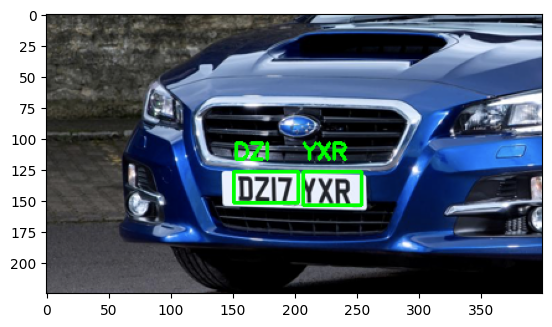

In [7]:
test_image = cv2.imread('images\cars\Cars3.png')
result_image, result_list = text_detection(test_image, max_img=5, size=(256,224), min_confidence=0.8)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

In [9]:
with gr.Blocks() as demo:
    gr.Markdown("## Detect and recognize text in image")
    max_img = gr.Slider(1,10,step=1,label='Max Output')
    with gr.Row():
        image_input = gr.Image()
        image_output = gr.Image()
    image_button = gr.Button("Detect")
    
    detect_list = gr.Textbox(label='Output')
    
    image_button.click(text_detection, inputs=[image_input, max_img], outputs=[image_output, detect_list])
    
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
